In [1]:
!pip install bertopic
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import kagglehub
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from bertopic import BERTopic
from wordcloud import WordCloud

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Download NLTK data:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

print("NLTK resources loaded successfully!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK resources loaded successfully!


In [4]:
# Load reviews dataset:
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
df = pd.read_csv(f"{path}/Reviews.csv")
df = df[['Text', 'Score']].rename(columns={'Text': 'review', 'Score': 'rating'})
df = df.dropna()
print(f"Loaded {len(df)} Amazon food reviews using kagglehub")


df = df.dropna()
df = df[df['review'].str.len() > 10]
if len(df) > 3000:
    df = df.sample(n=3000, random_state=42)

print(f"Final dataset shape: {df.shape}")
print(df.head())


Loaded 568454 Amazon food reviews using kagglehub
Final dataset shape: (3000, 2)
                                                   review  rating
165256  Having tried a couple of other brands of glute...       5
231465  My cat loves these treats. If ever I can't fin...       5
427827  A little less than I expected.  It tends to ha...       3
433954  First there was Frosted Mini-Wheats, in origin...       2
70260   and I want to congratulate the graphic artist ...       5


In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Clean, remove stop words, and lemmatize text"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase and remove special characters.
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)

    # Tokenize, remove stop words, and lemmatize.
    tokens = word_tokenize(text)
    processed_tokens = []
    for token in tokens:
        if token not in stop_words and len(token) > 2:
            lemmatized = lemmatizer.lemmatize(token)
            processed_tokens.append(lemmatized)

    return ' '.join(processed_tokens)

# Apply preprocessing:
print("Preprocessing text data...")
df['cleaned_review'] = df['review'].apply(preprocess_text)
df = df[df['cleaned_review'].str.len() > 0]

# Filter out very short reviews (less than 3 words):
df['word_count'] = df['cleaned_review'].str.split().str.len()
df = df[df['word_count'] >= 3]

print(f"After preprocessing: {len(df)} reviews remaining")
print(f"Example - Original: {df['review'].iloc[0]}")
print(f"Example - Cleaned: {df['cleaned_review'].iloc[0]}")


Preprocessing text data...
After preprocessing: 3000 reviews remaining
Example - Original: Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch.  They're crunchy and true to the texture of the other "real" cookies that aren't gluten-free.  Some might think that the filling makes them a bit too sweet, but for me that just means I've satisfied my sweet tooth sooner!  The chocolate version from Glutino is just as good and has a true "chocolatey" taste - something that isn't there with the other gluten-free brands out there.
Example - Cleaned: tried couple brand glutenfree sandwich cooky best bunch theyre crunchy true texture real cooky arent glutenfree might think filling make bit sweet mean ive satisfied sweet tooth sooner chocolate version glutino good true chocolatey taste something isnt glutenfree brand


In [6]:
# Prepare documents for BERTopic:
documents = df['cleaned_review'].tolist()
print(f"Prepared {len(documents)} documents for topic modeling")

# Initialize and train BERTopic model:
topic_model = BERTopic(
    language="english",
    calculate_probabilities=True,
    verbose=True
)

print("Training BERTopic model...")
topics, probs = topic_model.fit_transform(documents)

print(f"Topic modeling complete! Discovered {len(set(topics))} topics")
print(f"Number of outliers (topic -1): {topics.count(-1)}")

# Add topics to dataframe:
df['topic'] = topics
df['topic_probability'] = probs.max(axis=1) if probs is not None else None

# Get topic information:
topic_info = topic_model.get_topic_info()
print("\nTopic Information:")
print(topic_info.head())


2025-07-16 15:52:45,395 - BERTopic - Embedding - Transforming documents to embeddings.


Prepared 3000 documents for topic modeling
Training BERTopic model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2025-07-16 15:52:58,352 - BERTopic - Embedding - Completed ✓
2025-07-16 15:52:58,353 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-16 15:53:19,211 - BERTopic - Dimensionality - Completed ✓
2025-07-16 15:53:19,213 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-16 15:53:19,642 - BERTopic - Cluster - Completed ✓
2025-07-16 15:53:19,649 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-16 15:53:19,796 - BERTopic - Representation - Completed ✓


Topic modeling complete! Discovered 45 topics
Number of outliers (topic -1): 939

Topic Information:
   Topic  Count                          Name  \
0     -1    939  -1_product_taste_like_flavor   
1      0    376     0_coffee_cup_roast_strong   
2      1    268         1_dog_food_treat_love   
3      2    213         2_tea_green_bag_stash   
4      3     86         3_cat_food_dry_kitten   

                                      Representation  \
0  [product, taste, like, flavor, great, one, goo...   
1  [coffee, cup, roast, strong, kcups, bold, good...   
2  [dog, food, treat, love, chew, pet, toy, one, ...   
3  [tea, green, bag, stash, flavor, drink, earl, ...   
4  [cat, food, dry, kitten, treat, kitty, eat, ch...   

                                 Representative_Docs  
0  [used buy product bulk wild oat havent able fi...  
1  [lover coffee try almost coffee product coffee...  
2  [spent hour researching dog food wolf pup tast...  
3  [stash lemon ginger caffeine free herbal tea

In [7]:
# Fine-tune BERTopic parameters:
topic_info = topic_model.get_topic_info()
num_topics = len(topic_info) - 1

if num_topics > 10:
    print(f"Reducing {num_topics} topics to 10 for better interpretability...")
    topic_model.reduce_topics(documents, nr_topics=10)

    # Get new topic assignments:
    new_topics = topic_model.transform(documents)[0]
    df['topic'] = new_topics

    # Update topic info:
    topic_info = topic_model.get_topic_info()
    print(f"Topics reduced to {len(topic_info) - 1}")
else:
    print(f"Using {num_topics} topics (no reduction needed)")

# Show top topics with examples:
print("\nTop 5 topics with examples:")
for i, topic in enumerate(topic_info['Topic'][:5]):
    if topic != -1:  # Skip outlier topic.
        print(f"\nTopic {topic}: {topic_info.iloc[i]['Name']}")
        print(f"Count: {topic_info.iloc[i]['Count']}")

        # Get representative documents.
        topic_docs = df[df['topic'] == topic]
        if len(topic_docs) > 0:
            sample_doc = topic_docs.sample(1)['review'].iloc[0]
            print(f"  Example: {sample_doc[:100]}...")


2025-07-16 15:53:55,450 - BERTopic - Topic reduction - Reducing number of topics
2025-07-16 15:53:55,464 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-16 15:53:55,626 - BERTopic - Representation - Completed ✓
2025-07-16 15:53:55,628 - BERTopic - Topic reduction - Reduced number of topics from 45 to 10


Reducing 44 topics to 10 for better interpretability...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2025-07-16 15:53:57,671 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-16 15:53:57,681 - BERTopic - Dimensionality - Completed ✓
2025-07-16 15:53:57,681 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-16 15:53:57,759 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-16 15:53:58,529 - BERTopic - Probabilities - Completed ✓
2025-07-16 15:53:58,532 - BERTopic - Cluster - Completed ✓


Topics reduced to 9

Top 5 topics with examples:

Topic 0: 0_like_taste_flavor_good
Count: 743
  Example: Woo hoo! I just signed up for the subscribe and save and I am getting these for $.91 each! I bought ...

Topic 1: 1_coffee_tea_cup_flavor
Count: 610
  Example: the coffee is shipped in 4 boxes each pod is wrapped for freshness the cup of coffee tastes real goo...

Topic 2: 2_dog_food_cat_treat
Count: 354
  Example: I have a 95lb pitbull/ mastiff mix that often loves his rope bone and his squeaker toy and thought i...

Topic 3: 3_product_box_item_price
Count: 138
  Example: I bought this same brand at a local health food store.  For 1 oz. it cost $7.99.  So, when I bought ...


In [8]:
# Topic frequency visualization:
fig_freq = topic_model.visualize_barchart(height=500)
fig_freq.update_layout(title="Topic Frequency Distribution")
fig_freq.show()

# Topic frequency summary:
topic_counts = df['topic'].value_counts().sort_index()
topic_counts = topic_counts[topic_counts.index != -1]

print("\nTopic Frequency Summary:")
for topic_id, count in topic_counts.items():
    topic_name = topic_info[topic_info['Topic'] == topic_id]['Name'].iloc[0]
    percentage = (count / len(df)) * 100
    print(f"Topic {topic_id}: {topic_name} - {count} documents ({percentage:.1f}%)")



Topic Frequency Summary:
Topic 0: 0_like_taste_flavor_good - 743 documents (24.8%)
Topic 1: 1_coffee_tea_cup_flavor - 610 documents (20.3%)
Topic 2: 2_dog_food_cat_treat - 354 documents (11.8%)
Topic 3: 3_product_box_item_price - 138 documents (4.6%)
Topic 4: 4_hair_oil_coconut_product - 88 documents (2.9%)
Topic 5: 5_gluten_free_pasta_cooky - 56 documents (1.9%)
Topic 6: 6_cake_fondant_waffle_pancake - 32 documents (1.1%)
Topic 7: 7_salt_sea_taste_vinegar - 25 documents (0.8%)
Topic 8: 8_plant_kit_garden_grow - 15 documents (0.5%)


Generating word clouds for top topics...


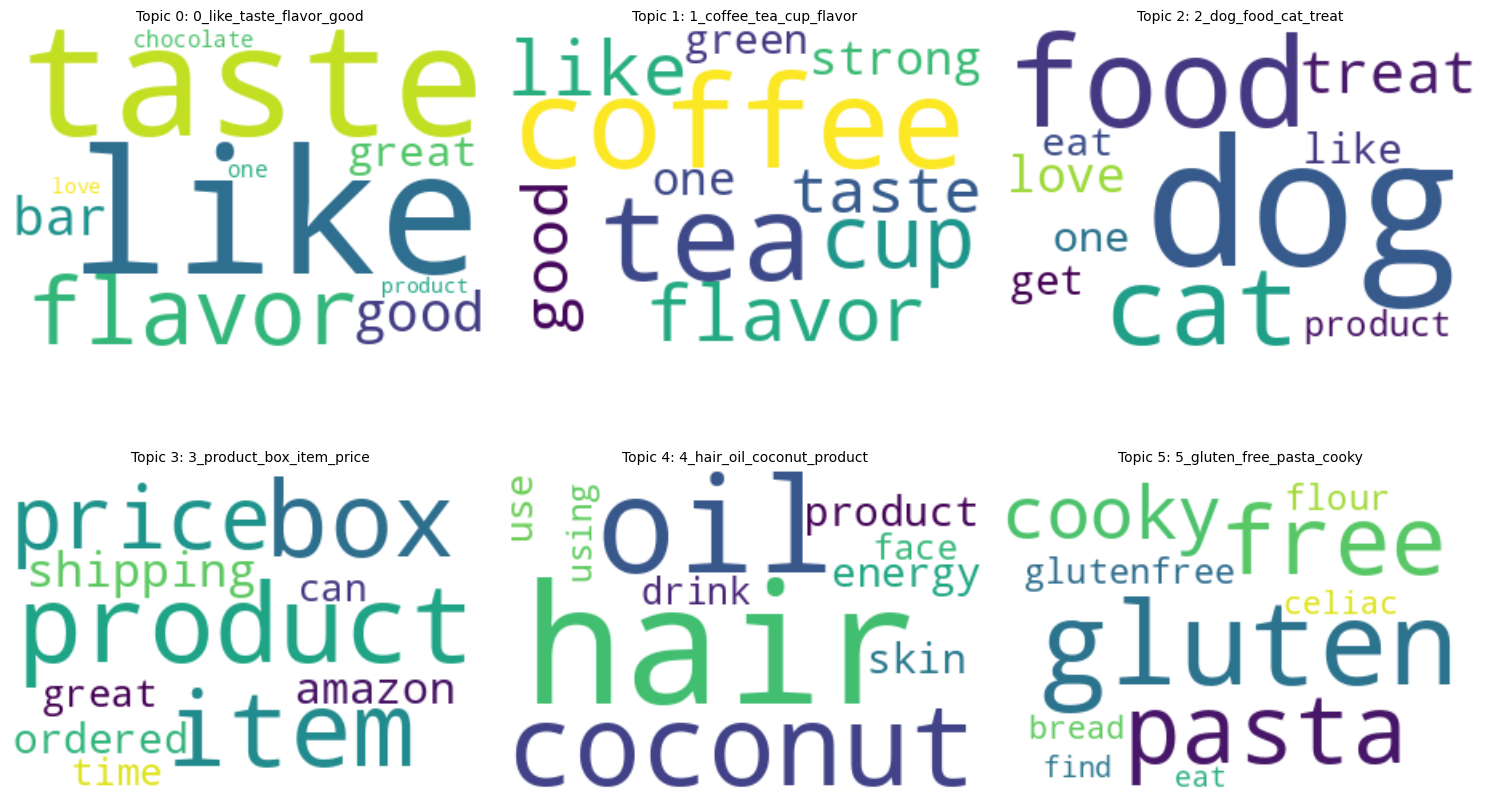

In [9]:
# Topic word clouds:
print("Generating word clouds for top topics...")
top_topics = topic_info[topic_info['Topic'] != -1].head(6)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (_, topic_row) in enumerate(top_topics.iterrows()):
    topic_id = topic_row['Topic']
    topic_name = topic_row['Name']

    # Get topic words and scores:
    topic_words = topic_model.get_topic(topic_id)

    if topic_words:
        # Create word frequency dictionary:
        word_freq = {word: score for word, score in topic_words}

        # Generate word cloud:
        wordcloud = WordCloud(
            width=300, height=200,
            background_color='white',
            colormap='viridis',
            max_words=30
        ).generate_from_frequencies(word_freq)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Topic {topic_id}: {topic_name}', fontsize=10)
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f'Topic {topic_id}\nNo words found',
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Topic {topic_id}: {topic_name}', fontsize=10)
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [10]:
# Visualize topic hierarchy and inter-topic distance map:
try:
    # Topic hierarchy.
    hierarchical_topics = topic_model.hierarchical_topics(documents)
    fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, height=600)
    fig_hierarchy.update_layout(title="Topic Hierarchy")
    fig_hierarchy.show()
except Exception as e:
    print(f"Could not generate hierarchy visualization: {e}")

try:
    # Inter-topic distance map.
    fig_topics = topic_model.visualize_topics(height=600)
    fig_topics.update_layout(title="Inter-topic Distance Map")
    fig_topics.show()
except Exception as e:
    print(f"Could not generate topic distance map: {e}")

try:
    # Topic similarity heatmap.
    fig_heatmap = topic_model.visualize_heatmap(height=600)
    fig_heatmap.update_layout(title="Topic Similarity Heatmap")
    fig_heatmap.show()
except Exception as e:
    print(f"Could not generate heatmap: {e}")


100%|██████████| 8/8 [00:00<00:00, 273.91it/s]
